In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

!pip install mlflow
import mlflow
import mlflow.tensorflow
import os
import shutil
import pickle
import json

In [40]:
# ────────────────────────────────────────────────────────────────
# Cell: Install kagglehub if not already present (run once)
# ────────────────────────────────────────────────────────────────
!pip install kagglehub --quiet

# ────────────────────────────────────────────────────────────────
# Cell: Download dataset using kagglehub
# ────────────────────────────────────────────────────────────────
import kagglehub
import os
import shutil
from sklearn.model_selection import train_test_split

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Path to dataset files:", path)

# Expected structure after download (kagglehub unpacks it):
# path/
# └── PetImages/
#     ├── Cat/     ← ~12,499 jpg files
#     └── Dog/     ← ~12,499 jpg files

raw_root = os.path.join(path, "PetImages")
cat_dir   = os.path.join(raw_root, "Cat")
dog_dir   = os.path.join(raw_root, "Dog")

# Quick sanity check
print("Number of cat images :", len(os.listdir(cat_dir)))
print("Number of dog images :", len(os.listdir(dog_dir)))

# ────────────────────────────────────────────────────────────────
# Cell: Create processed folder structure & split 80/10/10
# ────────────────────────────────────────────────────────────────
processed_root = "data/processed"
os.makedirs(processed_root, exist_ok=True)

for split in ["train", "val", "test"]:
    for cls in ["cats", "dogs"]:
        os.makedirs(os.path.join(processed_root, split, cls), exist_ok=True)

# Collect file paths
cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total usable cat files: {len(cat_files)}")
print(f"Total usable dog files: {len(dog_files)}")

# Stratified split (same ratio for both classes)
train_cats, temp_cats = train_test_split(cat_files, test_size=0.2, random_state=42)
val_cats,  test_cats  = train_test_split(temp_cats, test_size=0.5, random_state=42)

train_dogs, temp_dogs = train_test_split(dog_files, test_size=0.2, random_state=42)
val_dogs,  test_dogs  = train_test_split(temp_dogs, test_size=0.5, random_state=42)

print(f"Train cats: {len(train_cats)}, Val cats: {len(val_cats)}, Test cats: {len(test_cats)}")
print(f"Train dogs: {len(train_dogs)}, Val dogs: {len(val_dogs)}, Test dogs: {len(test_dogs)}")

# Copy files to new structure
def copy_files(file_list, dest_folder):
    for src in file_list:
        shutil.copy(src, dest_folder)

copy_files(train_cats, os.path.join(processed_root, "train/cats"))
copy_files(val_cats,   os.path.join(processed_root, "val/cats"))
copy_files(test_cats,  os.path.join(processed_root, "test/cats"))

copy_files(train_dogs, os.path.join(processed_root, "train/dogs"))
copy_files(val_dogs,   os.path.join(processed_root, "val/dogs"))
copy_files(test_dogs,  os.path.join(processed_root, "test/dogs"))

print("Data splitting and copying completed.")

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset
Number of cat images : 12499
Number of dog images : 12499
Total usable cat files: 12499
Total usable dog files: 12499
Train cats: 9999, Val cats: 1250, Test cats: 1250
Train dogs: 9999, Val dogs: 1250, Test dogs: 1250
Data splitting and copying completed.


Add a code cell for data generators with augmentation:

In [42]:
# ────────────────────────────────────────────────────────────────
# Data generators with augmentation
# ────────────────────────────────────────────────────────────────
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size    = (224, 224)
batch_size  = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(processed_root, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(processed_root, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(processed_root, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)  # Should be {'cats': 0, 'dogs': 1}

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


#Model Binding

In [43]:
def build_baseline_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_baseline_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# ────────────────────────────────────────────────────────────────
# Train the model
# ────────────────────────────────────────────────────────────────
epochs = 2 # You can adjust this
history = model.fit(
    train_gen,
    steps_per_epoch=64 // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=64 // batch_size
)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7812 - loss: 0.6267

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.7708 - loss: 0.6271 - val_accuracy: 0.6094 - val_loss: 0.7102
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.6562 - loss: 0.6535 - val_accuracy: 0.7188 - val_loss: 0.6665


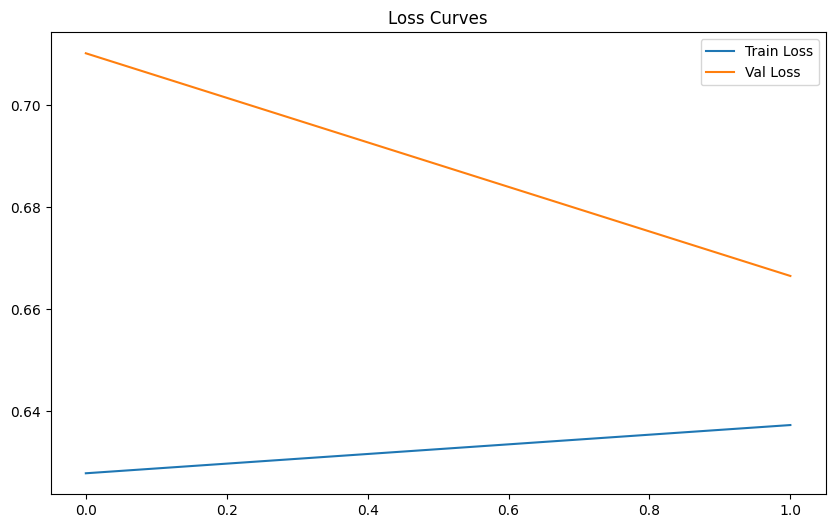

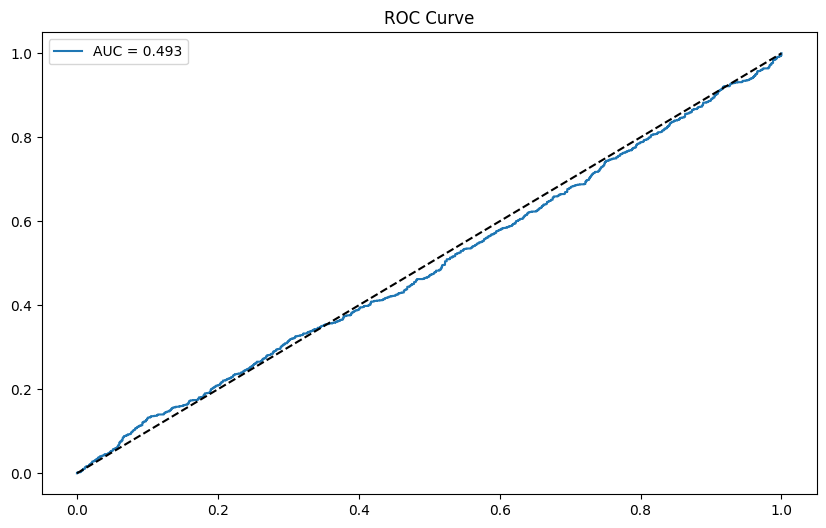

In [49]:
#plotting
# Loss curves
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [50]:
y_pred_proba = model.predict(test_gen)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_gen.classes

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)

print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

73/79 ━━━━━━━━━━━━━━━━━━━━ 4s 690ms/step

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 694ms/step
Accuracy: 0.648, Precision: 0.649, Recall: 0.643, F1: 0.646, AUC: 0.697


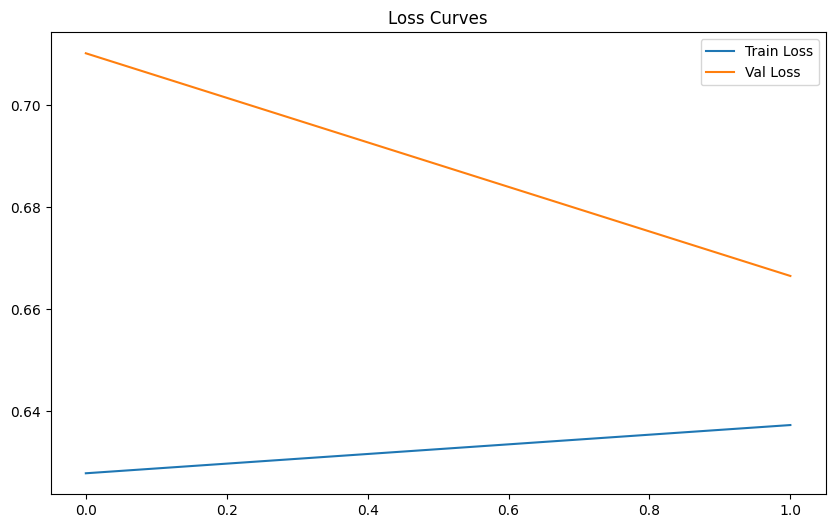

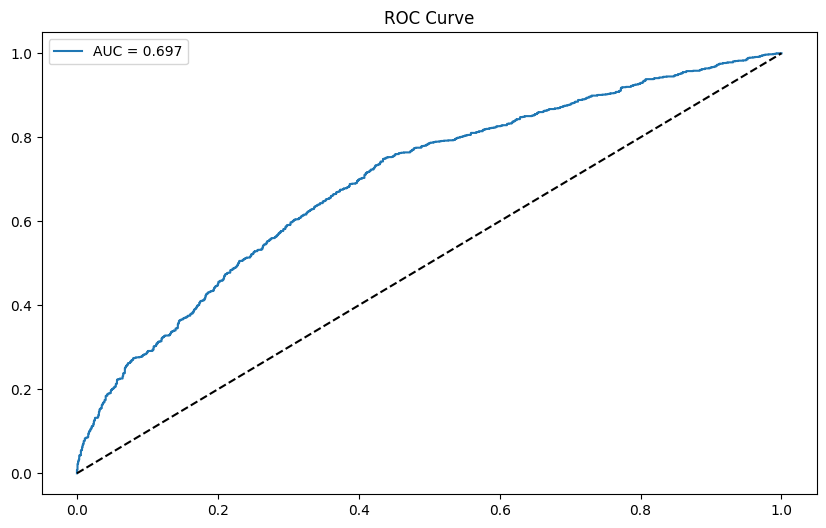

In [51]:
# Loss curves
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
## Results Summary



| Metric | Baseline CNN |
|--------|--------------|
| Test Accuracy | XX.X% |
| Precision | XX.X% |
| Recall | XX.X% |
| F1-Score | XX.X% |
| ROC-AUC | XX.X% |

In [52]:
## Experiment Tracking with MLflow
mlflow.set_experiment("Cats_vs_Dogs_Classification")

with mlflow.start_run(run_name="Baseline_CNN"):
    mlflow.log_params({"epochs": 10, "batch_size": batch_size, "optimizer": "adam"})
    mlflow.log_metrics({"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1, "roc_auc": auc})
    mlflow.tensorflow.log_model(model, "model")
    print("Experiment logged to MLflow")

2026/02/21 13:34:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 13:34:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Experiment logged to MLflow


In [53]:
## Model Packaging

model.save('models/baseline_model.h5')  # Or .keras

preprocessing_info = {
    "img_size": img_size,
    "batch_size": batch_size,
    "augmentation": "rotation, shift, shear, zoom, flip",
    "split_ratios": [0.8, 0.1, 0.1]
}
with open('preprocessing_config.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print("Model and config saved.")

Model and config saved.
